In [263]:
# Dependencies
import requests
import logging
import pandas as pd

In [264]:
# Define URL parameters
league_id = "564698"
year = ['2023','2022','2021','2020','2019','2018']

In [265]:
swid = "{823B7B7A-5AFC-4B2E-A22A-B2D690D236A8}"
espn_s2 = "AEBMf%2FfmL20PESZFBMdSRkR9HHsxOE%2FvAirc8HkQxtgX9tbG8vsxqa8Qm83LNJam6rJeMAWfmMVt3b2EuNYu7%2FATa0vER%2FTQIfoZRRg4ItNjN8MkU%2FBdNeTsOGei2ZJDgGX3zWxfxkysoQgRaVkikEHDHZtxlY9ZBtk3NrSUE%2BlaTWzbsfsEGlIgNzN4YG4QuUV7GxteDw1hUd%2Fb2sfdvew0ypoKcXrE51OQL5AgdfnH144uN1YmgFd3nNdBe%2FBIadjuJ2TZ7LAzAI7z1P6x7QhiG1Ah7RMTEzO7MDzoLdMODQ%3D%3D"

In [266]:
seasons = []
for yr in year:
    url = "https://lm-api-communication.fantasy.espn.com/apis/v3/games/ffl/seasons/"+yr+"/segments/0/leagues/564698"
    matchup_response = requests.get(url, cookies={"swid": swid,
                          "espn_s2": espn_s2},params={"view": "mMatchup"})
    matchup_json = matchup_response.json()
    df = [
    [
        game['matchupPeriodId'],
        game['home']['teamId'], 
        game['home'].get('totalPoints', 0),  # Using .get() to handle missing points
        game.get('away', {}).get('teamId', 'N/A'),  # Defaulting to 'N/A' if 'away' key is missing
        game.get('away', {}).get('totalPoints', 0)  # Defaulting to 0 if 'away' key or totalPoints is missing
    ]
    for game in matchup_json['schedule']
    ]
    df = pd.DataFrame(df, columns=['Week', 'HomeTeamId', 'HomeTotalPoints', 'AwayTeamId', 'AwayTotalPoints'])
    df['Type'] = ['Regular' if w<=14 else 'Playoff' for w in df['Week']]
    df['Year'] = yr
    seasons.append(df)

In [267]:
df_sch = pd.concat(seasons)

In [268]:
seasons_tm = []
for yr in year:
    url = "https://lm-api-communication.fantasy.espn.com/apis/v3/games/ffl/seasons/"+yr+"/segments/0/leagues/564698"
    team_response = requests.get(url, cookies={"swid": swid,
                          "espn_s2": espn_s2},params={"view": "forTeamId"})
    team_json = team_response.json()
    tm = [
    [
        team['abbrev'],
        team['id'],
        team['owners']
    ]
    for team in team_json['teams']
    ]
    
    tm1 = pd.DataFrame(tm, columns=['Abbr', 'TeamID','OwnerID_2'])

    tm = [
    [
        team['displayName'],
        team['id'],
    ]
    for team in team_json['members']
    ]
    
    tm2 = pd.DataFrame(tm, columns=['displayName','OwnerID'])

    # Creating the Cartesian product directly
    dataFrameFull = pd.merge(tm1, tm2, how='cross')

    # Checking if OwnerID_2 is a substring of OwnerID
    dataFrameFull['match'] = dataFrameFull.apply(lambda x: x.OwnerID in x.OwnerID_2, axis=1)
    
    dataFrameFull['Year'] = yr
    seasons_tm.append(dataFrameFull[dataFrameFull['match']])

In [269]:
df_tm = pd.concat(seasons_tm)

In [270]:
seasons_tm_1 = []
for yr in year:
    url = "https://lm-api-communication.fantasy.espn.com/apis/v3/games/ffl/seasons/"+yr+"/segments/0/leagues/564698"
    team_response = requests.get(url, cookies={"swid": swid,
                          "espn_s2": espn_s2},params={"view": "mTeam"})
    team_json = team_response.json()
    tm = [
    [
        team['displayName'],
        team['firstName'],
        team['lastName'],
        team['id']
    ]
    for team in team_json['members']
    ]
    
    tm1 = pd.DataFrame(tm, columns=['DisplayName', 'First','Last','OwnerID'])
    tm1['Year'] = yr
    seasons_tm_1.append(tm1)

In [271]:
df_tm1 = pd.concat(seasons_tm_1)

In [272]:
#df_tm.merge(df_tm1).groupby(['TeamID'])['OwnerID'].nunique()

In [273]:
slotcodes = {
    0 : 'QB', 1 : 'QB',
    2 : 'RB', 3 : 'RB',
    4 : 'WR', 5 : 'WR',
    6 : 'TE', 7 : 'TE',
    16: 'D/ST',
    17: 'K',
    20: 'Bench',
    21: 'IR',
    23: 'Flex'
}

In [274]:
def get_matchups(league_id, season, week, swid='', espn=''):
    ''' 
    Pull full JSON of matchup data from ESPN API for a particular week.
    '''
    
    url = 'https://lm-api-reads.fantasy.espn.com/apis/v3/games/ffl/seasons/'+str(season) + '/segments/0/leagues/' + str(league_id)+'?scoringPeriodId='+str(week)+ '&view=mMatchup&view=mMatchupScore' 

    r = requests.get(url,
                     cookies={"SWID": swid, "espn_s2": espn})
    return r.json()

def get_slates(json,season, week):
    '''
    Constructs week team slates with slotted position, 
    position, and points (actual and ESPN projected),
    given full matchup info (`get_matchups`)
    '''
    
    slates = {}
    slates_ls = []

    for team in d['teams']:
        slate = []
        for p in team['roster']['entries']:
            # get name
            if p.get('playerPoolEntry') and p['playerPoolEntry'].get('player'):
                name = p['playerPoolEntry']['player']['fullName']
            else:
                name = "Unknown Player"

            # get actual lineup slot
            slotid = p['lineupSlotId']
            slot = slotcodes[slotid]

            # get projected and actual scores
            act, proj = 0, 0
            if p.get('playerPoolEntry') and p['playerPoolEntry'].get('player'):
                for stat in p['playerPoolEntry']['player']['stats']:
                    if stat['scoringPeriodId'] != week:
                        continue
                    if stat['statSourceId'] == 0:
                        act = stat['appliedTotal']
                    elif stat['statSourceId'] == 1:
                        proj = stat['appliedTotal']
                    else:
                        print('Error')
            else:
                continue

            # get type of player
            pos = 'Unk'
            if p.get('playerPoolEntry') and p['playerPoolEntry'].get('player'):
                ess = p['playerPoolEntry']['player']['eligibleSlots']
                if 0 in ess: pos = 'QB'
                elif 2 in ess: pos = 'RB'
                elif 4 in ess: pos = 'WR'
                elif 6 in ess: pos = 'TE'
                elif 16 in ess: pos = 'D/ST'
                elif 17 in ess: pos = 'K'
            else:
                continue
            #teamid = team['id']
            
            
            slate.append([name, season, week, slotid, slot, pos, act, proj])

        slate = pd.DataFrame(slate, columns=['Name','Year', 'Week', 'SlotID', 'Slot', 'Pos', 'Actual', 'Proj'])
        #slates_ls.append(slate)
        slates[team['id']] = slate

    return slates

def compute_pts(slates, posns, struc):
    '''
    Given slates (`get_slates`), compute total roster points:
    actual, optimal, and using ESPN projections.
    
    Parameters
    --------------
    slates : `dict` of `DataFrames`
        (from `get_slates`)
    posns : `list`
        roster positions, e.g. ['QB', 'RB', 'WR', 'TE']
    struc : `list`
        slots per position, e.g. [1,2,2,1]
        
    * This is not flexible enough to handle "weird" leagues
    like 6 Flex slots with constraints on # total RB/WR
    
    Returns
    --------------
    `dict` of `dict`s with actual, ESPN, and optimal points
    '''
    
    data = {}
    for tmid, slate in slates.items():
        pts = {'opts': 0, 'epts': 0, 'apts': 0}

        # ACTUAL STARTERS
        pts['apts'] = slate.query('Slot not in ["Bench", "IR"]').filter(['Actual']).sum().values[0]

        # OPTIMAL and ESPNPROJ STARTERS
        for method, cat in [('Actual', 'opts'), ('Proj', 'epts')]:
            flex_candidates_act = []
            flex_candidates_proj = []
            fcp = []
            for pos, num in zip(posns, struc):
                # actual/projection points, sorted by the respective method
                sorted_slate = slate.query('Pos == @pos').sort_values(by=method, ascending=False)
                #print(sorted_slate.info())
                #print(method, pos,sorted_slate.iloc[:num].filter(['Actual']).sum().values[0])
                # Sum up the points for the starters in this position
                
                pts[cat] += sorted_slate.iloc[:num].filter(['Actual']).sum().values[0]
                

                # Add the next best as a flex candidate
                if pos in ['RB', 'WR', 'TE'] and len(sorted_slate) > num:
                    if method=="Proj":
                        
                        flex_candidates_proj.append(sorted_slate.iloc[num:])
                    else:
                        flex_candidates_act.extend(sorted_slate.iloc[num:].filter(['Actual']).values[:, 0])
                    #print(method, pos,flex_candidates_act,fcp)
            if flex_candidates_proj:
                fcp.extend(pd.concat(flex_candidates_proj).sort_values(by="Proj").iloc[num:].filter(['Actual']).values[:, 0])
                #print(fcp)
                top_flex = fcp[-2:]
                pts[cat] += sum(top_flex)
                #print(tmid, pos,method, num , sum(top_flex))
            # Add the best flex option to the total
            if flex_candidates_act:
                top_flex = sorted(flex_candidates_act, reverse=True)[:2]
                pts[cat] += sum(top_flex)
                
                #print(tmid, pos,method, num , sum(top_flex))
        
        data[tmid] = pts
        
    return data

#def get_teamnames(league_id, season, week, swid='', espn=''):
    #url = 'https://lm-api-communication.fantasy.espn.com/apis/v3/games/ffl/seasons/' + \
      #str(season) + '/segments/0/leagues/' + str(league_id)
    
    #r = requests.get(url + '?view=mTeam',
                  #params={'scoringPeriodId': week},
                  #cookies={"SWID": swid, "espn_s2": espn})
    #d = r.json()
    
    #tm_names = {tm['id']: tm['location'].strip() + ' ' + tm['nickname'].strip() \
               # for tm in d['teams']}
    
    #return tm_names

In [275]:
league_id = 564698

yrs = [2023,2022,2021]
posns = ['QB', 'RB', 'WR', 'Flex', 'TE', 'D/ST']
struc = [1,2,2,2,1,1,1]

data = {}
slates = {}
ds = {}
print('Week:', end=' ')
for y in yrs:
    data[y] = {}   # Initialize the year-specific dictionary in data
    slates[y] = {} # Initialize the year-specific dictionary in slates
    ds[y] = {}
    for week in range(1,18):
        print(week, y, end=' ')
        d      = get_matchups(league_id, y, week, swid=swid, espn=espn_s2)
        wslate = get_slates(d, y, week)
        wdata  = compute_pts(wslate, posns, struc)
        data[y][week] = wdata
        slates[y][week] = wslate
        ds[y][week] = d

Week: 1 2023 2 2023 3 2023 4 2023 5 2023 6 2023 7 2023 8 2023 9 2023 10 2023 11 2023 12 2023 13 2023 14 2023 15 2023 16 2023 17 2023 1 2022 2 2022 3 2022 4 2022 5 2022 6 2022 7 2022 8 2022 9 2022 10 2022 11 2022 12 2022 13 2022 14 2022 15 2022 16 2022 17 2022 1 2021 2 2021 3 2021 4 2021 5 2021 6 2021 7 2021 8 2021 9 2021 10 2021 11 2021 12 2021 13 2021 14 2021 15 2021 16 2021 17 2021 

In [276]:
df1 = pd.DataFrame.from_dict(
    {(year, week, team): stats
     for year, weeks in data.items()
     for week, teams in weeks.items()
     for team, stats in teams.items()},
    orient='index'
)

df1.reset_index(inplace=True)
df1.columns = ['Year', 'Week', 'TeamID', 'Opts', 'Epts', 'Apts']

df1

,Year,Week,TeamID,Opts,Epts,Apts
0,2023,1,1,141.2,95.3,107.7
1,2023,1,2,168.1,110.7,134.3
2,2023,1,3,109.8,92.7,91.5
3,2023,1,5,105.7,89.9,92.4
4,2023,1,6,189.3,132.1,177.8
...,...,...,...,...,...,...
505,2021,17,7,117.6,114.3,99.9
506,2021,17,9,178.9,174.1,156.6
507,2021,17,10,214.4,190.7,190.7
508,2021,17,11,135.3,128.5,128.5


In [277]:
league_id = 564698

yrs = [2020,2019,2018]
posns = ['QB', 'RB', 'WR', 'Flex', 'TE', 'D/ST','K']
struc = [1,2,2,1,1,1,1]

data = {}
slates = {}
ds = {}
print('Week:', end=' ')
for y in yrs:
    data[y] = {}   # Initialize the year-specific dictionary in data
    slates[y] = {} # Initialize the year-specific dictionary in slates
    ds[y] = {}
    for week in range(1,18):
        print(week, y, end=' ')
        d      = get_matchups(league_id, y, week, swid=swid, espn=espn_s2)
        wslate = get_slates(d, y, week)
        wdata  = compute_pts(wslate, posns, struc)
        data[y][week] = wdata
        slates[y][week] = wslate
        ds[y][week] = d

Week: 1 2020 2 2020 3 2020 4 2020 5 2020 6 2020 7 2020 8 2020 9 2020 10 2020 11 2020 12 2020 13 2020 14 2020 15 2020 16 2020 17 2020 1 2019 2 2019 3 2019 4 2019 5 2019 6 2019 7 2019 8 2019 9 2019 10 2019 11 2019 12 2019 13 2019 14 2019 15 2019 16 2019 17 2019 1 2018 2 2018 3 2018 4 2018 5 2018 6 2018 7 2018 8 2018 9 2018 10 2018 11 2018 12 2018 13 2018 14 2018 15 2018 16 2018 17 2018 

In [278]:
df2 = pd.DataFrame.from_dict(
    {(year, week, team): stats
     for year, weeks in data.items()
     for week, teams in weeks.items()
     for team, stats in teams.items()},
    orient='index'
)

df2.reset_index(inplace=True)
df2.columns = ['Year', 'Week', 'TeamID', 'Opts', 'Epts', 'Apts']

df2

,Year,Week,TeamID,Opts,Epts,Apts
0,2020,1,1,170.0,158.0,148.8
1,2020,1,2,142.2,122.5,115.1
2,2020,1,3,193.1,177.8,171.6
3,2020,1,5,169.5,166.3,159.6
4,2020,1,6,145.8,134.0,127.5
...,...,...,...,...,...,...
505,2018,17,7,127.0,117.1,108.5
506,2018,17,9,121.5,83.8,78.9
507,2018,17,10,112.4,87.7,77.1
508,2018,17,11,130.5,122.0,88.0


In [279]:
df_pts = pd.concat([df1,df2])

In [280]:
df_pts

,Year,Week,TeamID,Opts,Epts,Apts
0,2023,1,1,141.2,95.3,107.7
1,2023,1,2,168.1,110.7,134.3
2,2023,1,3,109.8,92.7,91.5
3,2023,1,5,105.7,89.9,92.4
4,2023,1,6,189.3,132.1,177.8
...,...,...,...,...,...,...
505,2018,17,7,127.0,117.1,108.5
506,2018,17,9,121.5,83.8,78.9
507,2018,17,10,112.4,87.7,77.1
508,2018,17,11,130.5,122.0,88.0


In [281]:
df_pts['Year'] = df_pts['Year'].astype(str)

In [282]:
teams = df_tm.merge(df_tm1)

In [283]:
tm_owners = teams[['TeamID','Year','First','Last']]

In [284]:
tm_owners

,TeamID,Year,First,Last
0,1,2023,Seth,Miller
1,2,2023,Jeff,Heitzman
2,3,2023,Nick,Vgts
3,5,2023,Micah,Swank
4,6,2023,Dylan,Geissert
...,...,...,...,...
61,9,2018,Dave,Miller
62,9,2018,Alex,Otte
63,10,2018,Steve,Clausing
64,11,2018,Alex,Clausing


In [285]:
total_matchups = df_pts.merge(tm_owners)
#total_matchups.loc[(total_matchups['Year']=="2023")&(total_matchups['Week']==2)&(total_matchups['First']=="Kolby")]

In [286]:
total_matchups['First'] = total_matchups['First'].str.capitalize()
total_matchups['Last'] = total_matchups['Last'].str.capitalize()

In [287]:
total_matchups.drop_duplicates(inplace=True)

In [288]:
total_matchups['Full Name'] = total_matchups['First'] + " "+ total_matchups['Last']

In [289]:
df_sch['Matchup_ID'] = df_sch['Year'].astype(str) + df_sch['Week'].astype(str)  + df_sch['HomeTeamId'].astype(str) + df_sch['AwayTeamId'].astype(str) 

In [290]:
df_sch_a = df_sch[['Year','Week','Matchup_ID','Type','AwayTeamId']].rename(columns={'AwayTeamId':'TeamID'})
df_sch_h = df_sch[['Year','Week','Matchup_ID','Type','HomeTeamId']].rename(columns={'HomeTeamId':'TeamID'})
df_sch_1 = pd.concat([df_sch_a,df_sch_h])

In [291]:
df_sch_1

,Year,Week,Matchup_ID,Type,TeamID
0,2023,1,2023137,Regular,7
1,2023,1,2023161,Regular,1
2,2023,1,20231211,Regular,11
3,2023,1,20231510,Regular,10
4,2023,1,20231912,Regular,12
...,...,...,...,...,...
76,2018,16,201816212,Playoff,2
77,2018,16,20181675,Playoff,7
78,2018,16,201816911,Playoff,9
79,2018,16,20181636,Playoff,3


In [292]:
df_matchups = total_matchups.merge(df_sch_1,how='inner')

In [293]:
#df_matchups['']

In [294]:
df_matchups['Actual_Winner'] = df_matchups.groupby('Matchup_ID')['Apts'].transform(lambda x: (x == x.max()).astype(int))
df_matchups['Optimal_Winner'] = df_matchups.groupby('Matchup_ID')['Opts'].transform(lambda x: (x == x.max()).astype(int))
df_matchups['ESPN_Winner'] = df_matchups.groupby('Matchup_ID')['Epts'].transform(lambda x: (x == x.max()).astype(int))

In [295]:
df_matchups_1 = df_matchups.loc[df_matchups['Full Name']!='Dave Miller']

In [296]:
df_matchups_1['Optimal_Missed_Pts'] = df_matchups_1['Apts'] - df_matchups_1['Opts']
df_matchups_1['ESPN_missed_Pts'] = df_matchups_1['Apts'] - df_matchups_1['Epts']

/var/folders/sj/rsx4zyld6flczf6q6r20b1c80000gn/T/ipykernel_35177/1951970540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matchups_1['Optimal_Missed_Pts'] = df_matchups_1['Apts'] - df_matchups_1['Opts']
/var/folders/sj/rsx4zyld6flczf6q6r20b1c80000gn/T/ipykernel_35177/1951970540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matchups_1['ESPN_missed_Pts'] = df_matchups_1['Apts'] - df_matchups_1['Epts']


In [297]:
df_matchups_1.loc[df_matchups_1['Full Name']=='Nick  Vgts','Full Name']="Nick Vogts"
df_matchups_1.loc[df_matchups_1['Full Name']=='Nick Vgts','Full Name']="Nick Vogts"

In [298]:
df_matchups_1.columns

Index(['Year', 'Week', 'TeamID', 'Opts', 'Epts', 'Apts', 'First', 'Last',
       'Full Name', 'Matchup_ID', 'Type', 'Actual_Winner', 'Optimal_Winner',
       'ESPN_Winner', 'Optimal_Missed_Pts', 'ESPN_missed_Pts'],
      dtype='object')

In [299]:
df_sorted = df_matchups_1.sort_values(by=['Matchup_ID', 'TeamID']).reset_index(drop=True)

# Shift the Apts column up and down to align with the opponent's values
df_sorted['Opponent_Apts'] = df_sorted['Apts'].shift(-1)
df_sorted.loc[df_sorted['Matchup_ID'] != df_sorted['Matchup_ID'].shift(-1), 'Opponent_Apts'] = df_sorted['Apts'].shift(1)

df_sorted['Opponent_Opts'] = df_sorted['Opts'].shift(-1)
df_sorted.loc[df_sorted['Matchup_ID'] != df_sorted['Matchup_ID'].shift(-1), 'Opponent_Opts'] = df_sorted['Opts'].shift(1)

#df_sorted['Opponent_Opts'] = df_sorted['Opts'].shift(-1)
#df_sorted.loc[df_sorted['Matchup_ID'] != df_sorted['Matchup_ID'].shift(-1), 'Opponent_Opts'] = df_sorted['Opts'].shift(1)

df_matchups_2 = df_matchups_1.merge(df_sorted)



In [300]:
df_matchups_2

,Year,Week,TeamID,Opts,Epts,Apts,First,Last,Full Name,Matchup_ID,Type,Actual_Winner,Optimal_Winner,ESPN_Winner,Optimal_Missed_Pts,ESPN_missed_Pts,Opponent_Apts,Opponent_Opts
0,2023,1,1,141.2,95.3,107.7,Seth,Miller,Seth Miller,2023161,Regular,0,0,0,-33.5,12.4,177.8,189.3
1,2023,1,2,168.1,110.7,134.3,Jeff,Heitzman,Jeff Heitzman,20231211,Regular,1,1,0,-33.8,23.6,104.8,152.7
2,2023,1,3,109.8,92.7,91.5,Nick,Vgts,Nick Vogts,2023137,Regular,1,1,1,-18.3,-1.2,87.0,94.2
3,2023,1,5,105.7,89.9,92.4,Micah,Swank,Micah Swank,20231510,Regular,0,0,0,-13.3,2.5,140.1,156.1
4,2023,1,6,189.3,132.1,177.8,Dylan,Geissert,Dylan Geissert,2023161,Regular,1,1,1,-11.5,45.7,107.7,141.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,2018,16,7,140.8,104.6,63.2,Kolby,Moddelmog,Kolby Moddelmog,20181675,Playoff,0,1,0,-77.6,-41.4,120.9,126.9
986,2018,16,9,203.7,168.7,161.3,Alex,Otte,Alex Otte,201816911,Playoff,1,1,1,-42.4,-7.4,110.8,147.3
987,2018,16,10,126.6,126.6,115.7,Steve,Clausing,Steve Clausing,201816101,Playoff,0,0,0,-10.9,-10.9,139.5,156.2
988,2018,16,11,147.3,129.8,110.8,Alex,Clausing,Alex Clausing,201816911,Playoff,0,0,0,-36.5,-19.0,161.3,203.7


In [301]:
df_Avg_Missed_Optimal = df_matchups_1.groupby(['Full Name'])["Optimal_Missed_Pts"].mean().reset_index().sort_values(by='Optimal_Missed_Pts')

In [302]:
import matplotlib.pyplot as plt


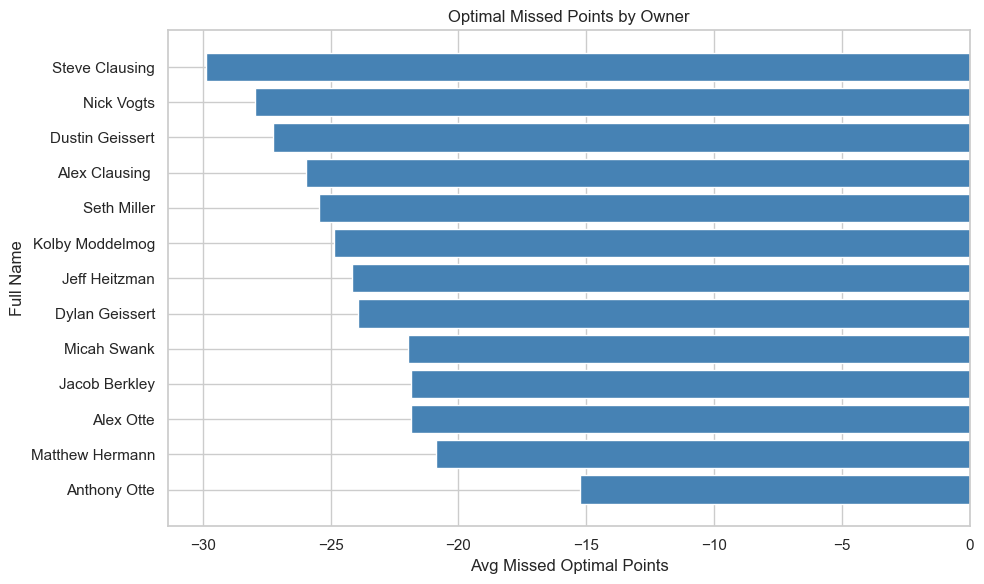

In [303]:
plt.figure(figsize=(10, 6))
plt.barh(df_Avg_Missed_Optimal['Full Name'], df_Avg_Missed_Optimal['Optimal_Missed_Pts'], color='steelblue')
plt.xlabel('Avg Missed Optimal Points')
plt.ylabel('Full Name')
plt.title('Optimal Missed Points by Owner')
plt.gca().invert_yaxis()  # Invert the y-axis to have the largest values at the top
plt.tight_layout()

# Show plot
plt.show()

In [304]:
df_ESPN_Mngr = df_matchups_1.groupby(['Full Name'])["ESPN_missed_Pts"].mean().reset_index().sort_values(by='ESPN_missed_Pts')

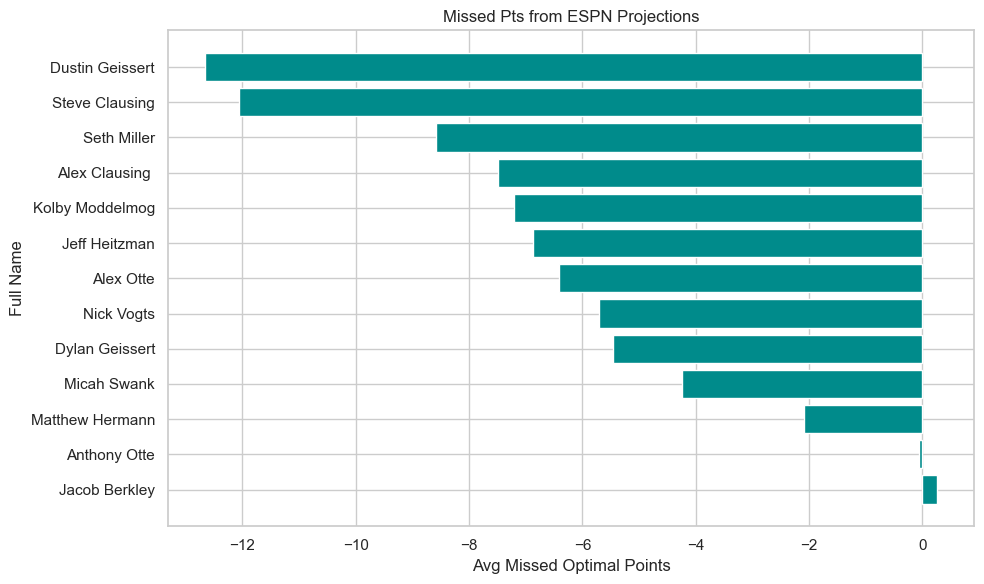

In [305]:
plt.figure(figsize=(10, 6))
plt.barh(df_ESPN_Mngr['Full Name'], df_ESPN_Mngr['ESPN_missed_Pts'], color='darkcyan')
plt.xlabel('Avg Missed Optimal Points')
plt.ylabel('Full Name')
plt.title('Missed Pts from ESPN Projections')
plt.gca().invert_yaxis()  # Invert the y-axis to have the largest values at the top
plt.tight_layout()

# Show plot
plt.show()

In [306]:
df_matchups_1.groupby(['Full Name','Year'])["Optimal_Missed_Pts"].mean().reset_index().sort_values(by='Optimal_Missed_Pts',ascending=False)

,Full Name,Year,Optimal_Missed_Pts
44,Micah Swank,2023,-10.705882
13,Anthony Otte,2022,-12.400000
3,Alex Clausing,2021,-12.617647
43,Micah Swank,2022,-13.200000
10,Alex Otte,2022,-13.800000
22,Dylan Geissert,2022,-14.458824
29,Jeff Heitzman,2022,-14.523529
54,Seth Miller,2021,-15.241176
12,Anthony Otte,2021,-16.494118
14,Anthony Otte,2023,-16.817647


In [307]:
df_opts_wins = df_matchups_1.groupby(['Full Name','Year'])[["Opts",'Actual_Winner']].sum().reset_index().sort_values(by='Opts',ascending=True)

In [308]:
df_opts_wins

,Full Name,Year,Opts,Actual_Winner
32,Kolby Moddelmog,2019,1982.4,6
57,Steve Clausing,2018,2046.8,6
1,Alex Clausing,2019,2174.7,5
26,Jeff Heitzman,2019,2214.2,9
18,Dylan Geissert,2018,2267.7,7
44,Micah Swank,2023,2268.6,7
10,Alex Otte,2022,2287.2,7
33,Kolby Moddelmog,2020,2287.8,7
36,Kolby Moddelmog,2023,2303.5,4
39,Micah Swank,2018,2309.9,8


In [309]:
df_Opts_Wins_Yrs = df_matchups_1.groupby(['Full Name']).agg({
    'Opts': 'sum',
    'Actual_Winner': 'sum',
    'Year': 'nunique',
    'Matchup_ID': 'count'}).reset_index()

In [310]:
df_Opts_Wins_Yrs['Opts/gm'] = (df_Opts_Wins_Yrs['Opts']/df_Opts_Wins_Yrs['Matchup_ID']).round(1)
df_Opts_Wins_Yrs['Opts/yr'] = (df_Opts_Wins_Yrs['Opts']/df_Opts_Wins_Yrs['Year']).round(1)
df_Opts_Wins_Yrs['Wins/yr'] = (df_Opts_Wins_Yrs['Actual_Winner']/df_Opts_Wins_Yrs['Year']).round(1)

In [311]:
df_Opts_Wins_Yrs

,Full Name,Opts,Actual_Winner,Year,Matchup_ID,Opts/gm,Opts/yr,Wins/yr
0,Alex Clausing,15375.5,47,6,99,155.3,2562.6,7.8
1,Alex Otte,14968.5,52,6,99,151.2,2494.8,8.7
2,Anthony Otte,7250.0,24,3,51,142.2,2416.7,8.0
3,Dustin Geissert,7852.1,33,3,48,163.6,2617.4,11.0
4,Dylan Geissert,15785.5,61,6,99,159.4,2630.9,10.2
5,Jacob Berkley,2528.4,8,1,17,148.7,2528.4,8.0
6,Jeff Heitzman,15428.4,57,6,99,155.8,2571.4,9.5
7,Kolby Moddelmog,13999.5,43,6,99,141.4,2333.2,7.2
8,Matthew Hermann,5320.3,16,2,34,156.5,2660.2,8.0
9,Micah Swank,14410.6,39,6,99,145.6,2401.8,6.5


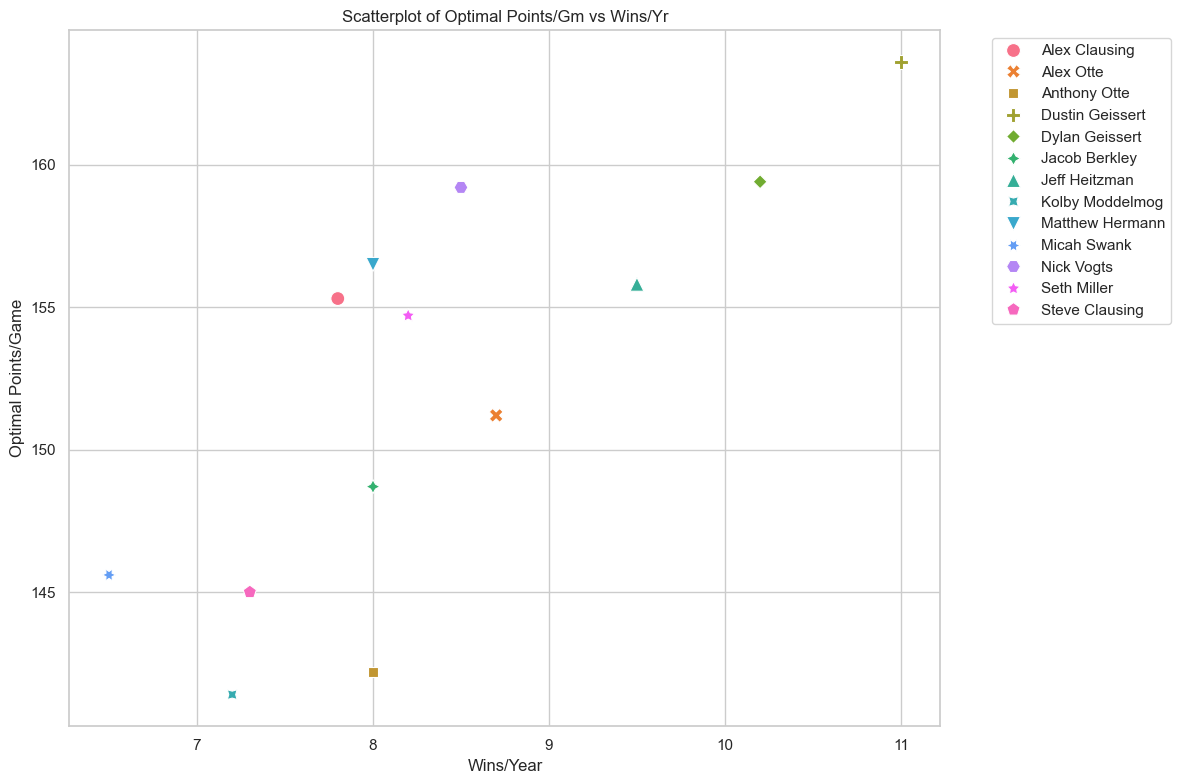

In [312]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create the scatterplot
sns.scatterplot(data=df_Opts_Wins_Yrs, x='Wins/yr', y='Opts/gm', hue='Full Name', style='Full Name', s=100)

# Add titles and labels
plt.title('Scatterplot of Optimal Points/Gm vs Wins/Yr')
plt.xlabel('Wins/Year')
plt.ylabel('Optimal Points/Game')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

In [319]:
df_opts_wins = df_matchups_1.groupby(['Full Name','Year'])[["Opts",'Actual_Winner']].sum().reset_index().sort_values(by='Opts',ascending=True)

In [316]:
#df_opts_wins

In [320]:
df_opts_wins['Name_Yr'] = df_opts_wins['Full Name']+"_"+df_opts_wins['Year']

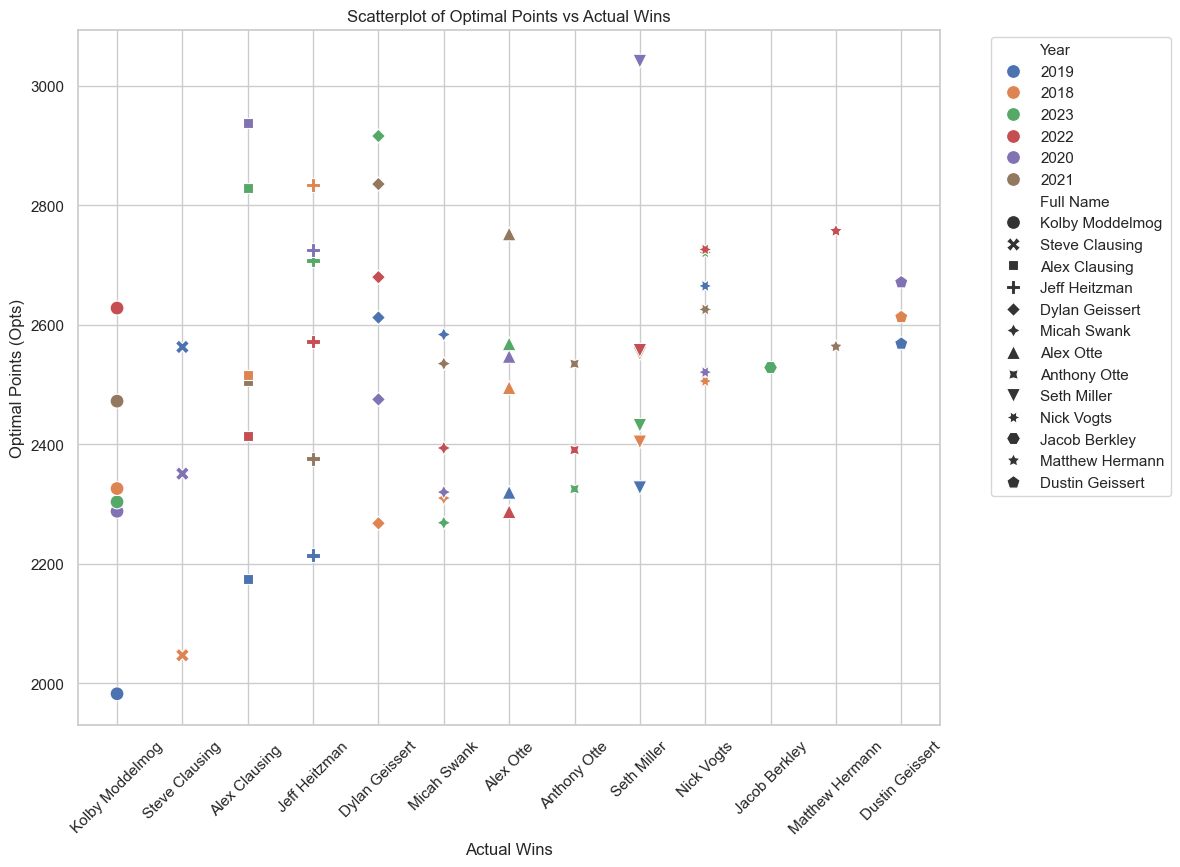

In [321]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create the scatterplot
sns.scatterplot(data=df_opts_wins, x='Full Name', y='Opts', hue='Year', style='Full Name', s=100)

# Add titles and labels
plt.title('Scatterplot of Optimal Points vs Actual Wins')
plt.xlabel('Actual Wins')
plt.ylabel('Optimal Points (Opts)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.xticks(rotation=45)


# Display the plot
plt.show()

In [322]:
df_matchups_2

,Year,Week,TeamID,Opts,Epts,Apts,First,Last,Full Name,Matchup_ID,Type,Actual_Winner,Optimal_Winner,ESPN_Winner,Optimal_Missed_Pts,ESPN_missed_Pts,Opponent_Apts,Opponent_Opts
0,2023,1,1,141.2,95.3,107.7,Seth,Miller,Seth Miller,2023161,Regular,0,0,0,-33.5,12.4,177.8,189.3
1,2023,1,2,168.1,110.7,134.3,Jeff,Heitzman,Jeff Heitzman,20231211,Regular,1,1,0,-33.8,23.6,104.8,152.7
2,2023,1,3,109.8,92.7,91.5,Nick,Vgts,Nick Vogts,2023137,Regular,1,1,1,-18.3,-1.2,87.0,94.2
3,2023,1,5,105.7,89.9,92.4,Micah,Swank,Micah Swank,20231510,Regular,0,0,0,-13.3,2.5,140.1,156.1
4,2023,1,6,189.3,132.1,177.8,Dylan,Geissert,Dylan Geissert,2023161,Regular,1,1,1,-11.5,45.7,107.7,141.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,2018,16,7,140.8,104.6,63.2,Kolby,Moddelmog,Kolby Moddelmog,20181675,Playoff,0,1,0,-77.6,-41.4,120.9,126.9
986,2018,16,9,203.7,168.7,161.3,Alex,Otte,Alex Otte,201816911,Playoff,1,1,1,-42.4,-7.4,110.8,147.3
987,2018,16,10,126.6,126.6,115.7,Steve,Clausing,Steve Clausing,201816101,Playoff,0,0,0,-10.9,-10.9,139.5,156.2
988,2018,16,11,147.3,129.8,110.8,Alex,Clausing,Alex Clausing,201816911,Playoff,0,0,0,-36.5,-19.0,161.3,203.7


In [323]:
df_matchup_stats = df_matchups_2.groupby(['Full Name',"Year"]).agg({
    'Optimal_Missed_Pts': 'sum',
    'Opts': 'sum',
    'Opponent_Opts': 'sum',
    'Actual_Winner': 'sum',
    'Optimal_Winner': 'sum',
    'ESPN_Winner': 'sum',
    'Matchup_ID': 'count'}).reset_index()

In [324]:
df_matchup_stats['Adjusted_Wins'] = df_matchup_stats['Optimal_Winner']-df_matchup_stats['Actual_Winner']

In [325]:
#df_matchup_stats.sort_values(by='Adjusted_Wins')

In [326]:
df_matchup_stats['Name_Year'] = df_matchup_stats['Full Name'] + ' ' + df_matchup_stats['Year'].astype(str)

In [327]:
df_matchup_stats.sort_values(by='Adjusted_Wins', inplace=True)

In [328]:
df_mstats_short = df_matchup_stats.loc[(df_matchup_stats['Adjusted_Wins']>1)|(df_matchup_stats['Adjusted_Wins']< -1)]

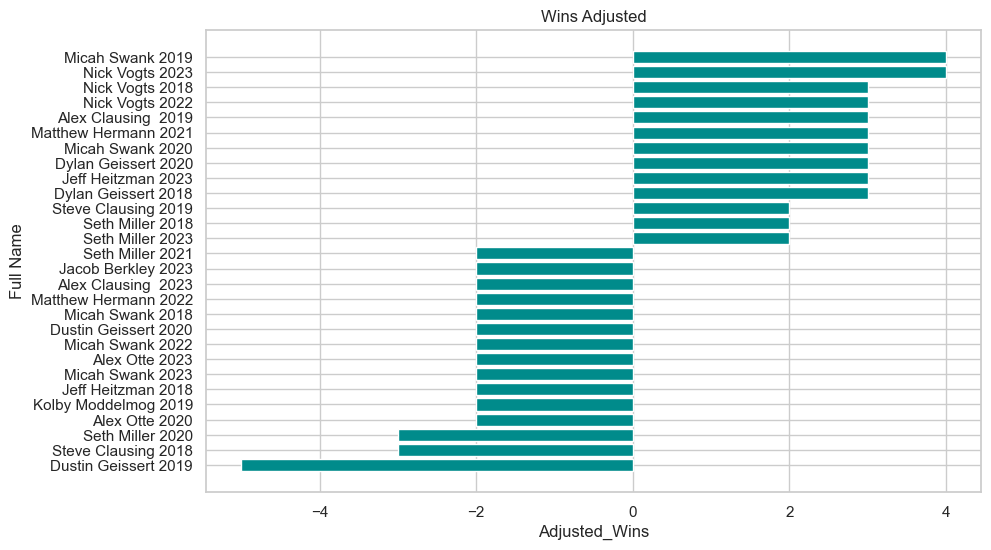

In [339]:
plt.figure(figsize=(10, 6))
plt.barh(df_mstats_short['Name_Year'], df_mstats_short['Adjusted_Wins'], color='darkcyan')
plt.xlabel('Adjusted_Wins')
plt.ylabel('Full Name')
plt.title('Wins Adjusted')
#plt.gca().invert_yaxis()  # Invert the y-axis to have the largest values at the top
#plt.tight_layout()

# Show plot
plt.show()

In [340]:
#df_mstats_short.info()

In [348]:
df_matchup_stats

,Full Name,Year,Type,Optimal_Missed_Pts,Opts,Opponent_Opts,Actual_Winner,Optimal_Winner,ESPN_Winner,Matchup_ID
0,Alex Clausing,2018,Playoff,-67.6,317.0,298.1,1,1,1,2
1,Alex Clausing,2018,Regular,-423.5,2198.2,2127.7,7,8,7,14
2,Alex Clausing,2019,Playoff,-50.5,283.5,277.3,1,1,1,2
3,Alex Clausing,2019,Regular,-480.4,1891.2,2085.3,4,7,6,14
4,Alex Clausing,2020,Playoff,-83.5,477.4,406.4,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...
115,Steve Clausing,2018,Regular,-303.4,1822.9,2184.4,6,3,5,14
116,Steve Clausing,2019,Playoff,-115.2,382.0,349.2,1,2,1,2
117,Steve Clausing,2019,Regular,-434.4,2180.8,1860.6,9,10,10,14
118,Steve Clausing,2020,Playoff,-52.1,358.6,273.4,1,1,2,2


In [330]:
#df_matchups_1.groupby(['Full Name','Year'])["Optimal_Missed_Pts"].mean().reset_index().sort_values(by='Optimal_Missed_Pts',ascending=False)

,Year,Week,TeamID,Opts,Epts,Apts,First,Last,Full Name,Matchup_ID,Type,Actual_Winner,Optimal_Winner,ESPN_Winner,Optimal_Missed_Pts,ESPN_missed_Pts,Opponent_Apts,Opponent_Opts
150,2023,16,1,141.7,132.9,108.9,Seth,Miller,Seth Miller,202316121,Playoff,0,0,1,-32.8,-2.400000e+01,127.5,142.6
151,2023,16,2,196.6,157.3,143.6,Jeff,Heitzman,Jeff Heitzman,202316210,Playoff,1,1,1,-53.0,-1.370000e+01,111.1,126.2
152,2023,16,3,125.1,101.9,114.3,Nick,Vgts,Nick Vogts,20231693,Playoff,1,1,1,-10.8,1.240000e+01,96.0,108.0
153,2023,16,5,188.8,179.8,179.8,Micah,Swank,Micah Swank,20231657,Playoff,1,1,1,-9.0,0.000000e+00,105.7,122.4
154,2023,16,6,173.6,132.8,135.5,Dylan,Geissert,Dylan Geissert,202316611,Playoff,0,1,0,-38.1,2.700000e+00,146.0,168.8
155,2023,16,7,122.4,93.8,105.7,Kolby,Moddelmog,Kolby Moddelmog,20231657,Playoff,0,0,0,-16.7,1.190000e+01,179.8,188.8
156,2023,16,9,108.0,96.0,96.0,Alex,Otte,Alex Otte,20231693,Playoff,0,0,0,-12.0,1.421085e-14,114.3,125.1
157,2023,16,10,126.2,111.1,111.1,Anthony,Otte,Anthony Otte,202316210,Playoff,0,0,0,-15.1,0.000000e+00,143.6,196.6
158,2023,16,11,168.8,146.0,146.0,Alex,Clausing,Alex Clausing,202316611,Playoff,1,0,1,-22.8,0.000000e+00,135.5,173.6
159,2023,16,12,142.6,132.1,127.5,Jacob,Berkley,Jacob Berkley,202316121,Playoff,1,1,0,-15.1,-4.600000e+00,108.9,141.7
